In [1]:
!pip install qiskit_aer qiskit[all]  -q
%pip install 'qbraid==0.9.6.dev20250425155658' -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, qasm2
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UGate
from qbraid import QbraidProvider
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import box

def qpe_qiskit(unitary_phase, psi_params=None, n_estimation_qubits=3, n_target_qubits=1):
    """
    Implements Quantum Phase Estimation using Qiskit with customizable eigenstate

    Args:
        unitary_phase: The eigenvalue phase to estimate (between 0 and 1)
        psi_params: Parameters [theta, phi, lambda] for the eigenstate initialization
                   If None, defaults to |1⟩ state
        n_estimation_qubits: Number of qubits used for estimation (precision)
        n_target_qubits: Number of qubits for the target state

    Returns:
        A quantum circuit for QPE
    """
    # Create quantum circuit with registers
    total_qubits = n_estimation_qubits + n_target_qubits + 1 # 1 for teleporation
    qc = QuantumCircuit(total_qubits, n_estimation_qubits)

    # Label registers for clarity
    estimation_qubits = list(range(n_estimation_qubits))
    target_qubit = list(range(n_estimation_qubits, total_qubits))

    # Initialize target qubit to |ψ⟩ (eigenstate of U)
    if psi_params is None:
        # Default to |1⟩ state
        qc.x(target_qubit[0])
    else:
        # Apply a general single-qubit unitary to create |ψ⟩
        theta, phi, lam = psi_params
        qc.u(theta, phi, lam, target_qubit[0])

        # For multi-qubit eigenstate initialization (if needed)
        if n_target_qubits > 1:
            # Here you would add more complex initialization
            # This is just a simple example that entangles the target qubits
            for i in range(1, n_target_qubits):
                qc.cx(target_qubit[0], target_qubit[i])

    # Apply Hadamard gates to estimation qubits
    for qubit in estimation_qubits:
        qc.h(qubit)

    # Apply controlled-U operations with increasing powers
    for i, qubit in enumerate(estimation_qubits):
        power = 2**(n_estimation_qubits - i - 1)

        # Controlled phase rotation - equivalent to controlled-U operation
        # where U has eigenvalue e^(2πi*unitary_phase)
        angle = 2 * np.pi * unitary_phase * power
        qc.cp(angle, qubit, target_qubit[0])

    # Apply inverse QFT to estimation qubits
    qc.barrier()

    # Inverse QFT implementation
    for i in range(n_estimation_qubits//2):
        qc.swap(i, n_estimation_qubits-i-1)

    for i in range(n_estimation_qubits):
        qc.h(i)
        for j in range(i+1, n_estimation_qubits):
            angle = -np.pi/float(2**(j-i))
            qc.cp(angle, j, i)

    # Measure estimation qubits
    qc.barrier()
    qc.measure(estimation_qubits, range(n_estimation_qubits))
    print(qasm2.dumps(qc))
    return qc

# def qpe_qiskit(unitary_phase, psi_params=None, n_estimation_qubits=3, n_target_qubits=1):
#     """
#     Implements Quantum Phase Estimation using Qiskit v2.0 with customizable eigenstate
#     and teleportation between q3 and q4

#     Args:
#         unitary_phase: The eigenvalue phase to estimate (between 0 and 1)
#         psi_params: Parameters [theta, phi, lambda] for the eigenstate initialization
#                    If None, defaults to |1⟩ state
#         n_estimation_qubits: Number of qubits used for estimation (precision)
#         n_target_qubits: Number of qubits for the target state

#     Returns:
#         A quantum circuit for QPE
#     """

#     # Create quantum circuit with registers
#     total_qubits = n_estimation_qubits + n_target_qubits + 1  # +1 for teleportation
#     qc = QuantumCircuit(total_qubits, n_estimation_qubits + 1)  # +1 classical bit for teleportation

#     # Label registers for clarity
#     estimation_qubits = list(range(n_estimation_qubits))
#     target_qubit = n_estimation_qubits  # q3
#     teleport_qubit = n_estimation_qubits + 1  # q4

#     # Initialize target qubit to |ψ⟩ (eigenstate of U)
#     if psi_params is None:
#         # Default to |1⟩ state
#         qc.x(teleport_qubit)  # We initialize q4 instead of q3 now
#     else:
#         # Apply a general single-qubit unitary to create |ψ⟩ on q4
#         theta, phi, lam = psi_params
#         qc.u(theta, phi, lam, teleport_qubit)

#     # Teleportation protocol to transfer state from q4 to q3
#     # Step 1: Create Bell pair between q3 and ancilla q4
#     qc.h(target_qubit)
#     qc.cx(target_qubit, teleport_qubit)

#     # Step 2: Apply Bell measurement on the state and q3
#     qc.cx(teleport_qubit, target_qubit)
#     qc.h(teleport_qubit)

#     # Step 3: Measure q4 and store result
#     qc.measure(teleport_qubit, n_estimation_qubits)

#     # Step 4: Apply classical correction based on measurement (if measurement is 1, apply X gate)
#     # Using if_test context manager instead of c_if method
#     with qc.if_test((n_estimation_qubits, 1)):
#         qc.x(target_qubit)

#     # Apply Hadamard gates to estimation qubits
#     for qubit in estimation_qubits:
#         qc.h(qubit)

#     # Apply controlled-U operations with increasing powers
#     for i, qubit in enumerate(estimation_qubits):
#         power = 2**(n_estimation_qubits - i - 1)

#         # Controlled phase rotation - equivalent to controlled-U operation
#         # where U has eigenvalue e^(2πi*unitary_phase)
#         angle = 2 * np.pi * unitary_phase * power
#         qc.cp(angle, qubit, target_qubit)

#     # Apply inverse QFT to estimation qubits
#     qc.barrier()

#     # Inverse QFT implementation
#     for i in range(n_estimation_qubits//2):
#         qc.swap(i, n_estimation_qubits-i-1)

#     for i in range(n_estimation_qubits):
#         qc.h(i)
#         for j in range(i+1, n_estimation_qubits):
#             angle = -np.pi/float(2**(j-i))
#             qc.cp(angle, j, i)

#     # Measure estimation qubits
#     qc.barrier()
#     qc.measure(estimation_qubits, range(n_estimation_qubits))

#     return qc

# def qpe_qiskit(unitary_phase, psi_params=None, n_estimation_qubits=3, n_target_qubits=1):
#     """
#     Implements Quantum Phase Estimation using Qiskit v2.0 with customizable eigenstate
#     and proper quantum teleportation between qubits.

#     Args:
#         unitary_phase: The eigenvalue phase to estimate (between 0 and 1)
#         psi_params: Parameters [theta, phi, lambda] for the eigenstate initialization
#                    If None, defaults to |1⟩ state
#         n_estimation_qubits: Number of qubits used for estimation (precision)
#         n_target_qubits: Number of qubits for the target state

#     Returns:
#         A quantum circuit for QPE
#     """

#     # Create quantum circuit with registers
#     # We need: estimation qubits + target qubit + 2 qubits for teleportation
#     total_qubits = n_estimation_qubits + n_target_qubits + 2
#     # Need 2 classical bits for teleportation measurements
#     qc = QuantumCircuit(total_qubits, n_estimation_qubits + 2)

#     # Label registers for clarity
#     estimation_qubits = list(range(n_estimation_qubits))
#     target_qubit = n_estimation_qubits  # q3 - where state will end up
#     teleport_aux1 = n_estimation_qubits + 1  # q4 - first teleportation auxiliary qubit
#     teleport_aux2 = n_estimation_qubits + 2  # q5 - second teleportation auxiliary qubit (holds initial state)

#     # Initialize the state to be teleported on teleport_aux2 (q5)
#     if psi_params is None:
#         # Default to |1⟩ state
#         qc.x(teleport_aux2)
#     else:
#         # Apply a general single-qubit unitary to create |ψ⟩
#         theta, phi, lam = psi_params
#         qc.u(theta, phi, lam, teleport_aux2)

#     # Prepare the Bell pair between target_qubit (q3) and teleport_aux1 (q4)
#     qc.h(target_qubit)
#     qc.cx(target_qubit, teleport_aux1)

#     # Teleportation protocol
#     # Bell measurement between state qubit (teleport_aux2) and auxiliary qubit (teleport_aux1)
#     qc.cx(teleport_aux2, teleport_aux1)
#     qc.h(teleport_aux2)

#     # Measure the auxiliary qubits
#     qc.measure(teleport_aux2, n_estimation_qubits)      # First teleportation bit
#     qc.measure(teleport_aux1, n_estimation_qubits + 1)  # Second teleportation bit

#     # Apply corrections based on measurement outcomes
#     # Apply X gate if the second measurement is 1
#     with qc.if_test((n_estimation_qubits + 1, 1)):
#         qc.x(target_qubit)

#     # Apply Z gate if the first measurement is 1
#     with qc.if_test((n_estimation_qubits, 1)):
#         qc.z(target_qubit)

#     # Now the state |ψ⟩ has been teleported to target_qubit (q3)

#     # Apply Hadamard gates to estimation qubits
#     for qubit in estimation_qubits:
#         qc.h(qubit)

#     # Apply controlled-U operations with increasing powers
#     for i, qubit in enumerate(estimation_qubits):
#         power = 2**(n_estimation_qubits - i - 1)

#         # Controlled phase rotation - equivalent to controlled-U operation
#         # where U has eigenvalue e^(2πi*unitary_phase)
#         angle = 2 * np.pi * unitary_phase * power
#         qc.cp(angle, qubit, target_qubit)

#     # Apply inverse QFT to estimation qubits
#     qc.barrier()

#     # Inverse QFT implementation
#     for i in range(n_estimation_qubits//2):
#         qc.swap(i, n_estimation_qubits-i-1)

#     for i in range(n_estimation_qubits):
#         qc.h(i)
#         for j in range(i+1, n_estimation_qubits):
#             angle = -np.pi/float(2**(j-i))
#             qc.cp(angle, j, i)

#     # Measure estimation qubits
#     qc.barrier()
#     qc.measure(estimation_qubits, range(n_estimation_qubits))

#     return qc

def calculate_hqc(circuit, shots):
    """
    Calculate Hardware Quantum Credits (HQC) based on the formula:
    HQC = 5 + C(N_1q + 10*N_2q + 5*N_m)/5000

    Args:
        circuit: Qiskit quantum circuit
        shots: Number of shots for the simulation

    Returns:
        HQC value and component counts
    """
    # Count operations by type
    op_counts = circuit.count_ops()

    # Categorize operations
    one_qubit_ops = 0
    two_qubit_ops = 0
    measurement_ops = 0

    # List of one-qubit gates in Qiskit
    one_qubit_gates = ['u1', 'u2', 'u3', 'u', 'p', 'x', 'y', 'z', 'h', 's', 't',
                       'sdg', 'tdg', 'rx', 'ry', 'rz', 'id']

    # List of two-qubit gates in Qiskit
    two_qubit_gates = ['cx', 'cz', 'cy', 'cp', 'cu', 'swap', 'iswap', 'dcx', 'ch', 'crz',
                       'cu1', 'cu3', 'rxx', 'ryy', 'rzz', 'xx', 'yy', 'zz']

    # List of measurement operations
    measurement_gates = ['measure', 'reset', 'barrier']

    # Count operations by category
    for gate, count in op_counts.items():
        if gate in one_qubit_gates:
            one_qubit_ops += count
        elif gate in two_qubit_gates:
            two_qubit_ops += count
        elif gate in measurement_gates:
            measurement_ops += count

    # Calculate HQC
    # Automatically count 1 measurement operation per qubit for initial state prep
    # if not explicitly included in the counts
    if 'reset' not in op_counts:
        measurement_ops += circuit.num_qubits

    # Apply the formula: HQC = 5 + C(N_1q + 10*N_2q + 5*N_m)/5000
    hqc = 5 + shots * (one_qubit_ops + 10 * two_qubit_ops + 5 * measurement_ops) / 5000

    return {
        'HQC': hqc,
        'one_qubit_ops': one_qubit_ops,
        'two_qubit_ops': two_qubit_ops,
        'measurement_ops': measurement_ops,
        'shots': shots
    }

def display_hqc_calculation(hqc_data, circuit_name):
    """
    Display the HQC calculation details using rich library

    Args:
        hqc_data: Dictionary containing HQC calculation data
        circuit_name: Name of the circuit for display purposes
    """
    console = Console()

    # Create a table for operation counts
    ops_table = Table(title=f"Operation Counts for {circuit_name}", box=box.ROUNDED)
    ops_table.add_column("Operation Type", style="cyan")
    ops_table.add_column("Count", style="green")

    ops_table.add_row("One-qubit Operations (N₁ₑ)", str(hqc_data['one_qubit_ops']))
    ops_table.add_row("Two-qubit Operations (N₂ₑ)", str(hqc_data['two_qubit_ops']))
    ops_table.add_row("Measurement Operations (Nₘ)", str(hqc_data['measurement_ops']))
    ops_table.add_row("Shot Count (C)", str(hqc_data['shots']))

    # Create HQC calculation panel
    formula = f"HQC = 5 + C(N₁ₑ + 10*N₂ₑ + 5*Nₘ)/5000"
    calculation = (f"HQC = 5 + {hqc_data['shots']}*({hqc_data['one_qubit_ops']} + "
                  f"10*{hqc_data['two_qubit_ops']} + 5*{hqc_data['measurement_ops']})/5000")
    result = f"HQC = 5 + {hqc_data['shots']}*{hqc_data['one_qubit_ops'] + 10*hqc_data['two_qubit_ops'] + 5*hqc_data['measurement_ops']}/5000"
    final = f"HQC = 5 + {(hqc_data['shots'] * (hqc_data['one_qubit_ops'] + 10*hqc_data['two_qubit_ops'] + 5*hqc_data['measurement_ops']))/5000:.4f}"
    final_result = f"HQC = {hqc_data['HQC']:.4f}"

    hqc_panel = Panel(
        f"{formula}\n\n{calculation}\n{result}\n{final}\n{final_result}",
        title="HQC Calculation",
        box=box.ROUNDED,
        border_style="blue"
    )

    # Display the information
    console.print(ops_table)
    console.print(hqc_panel)

def draw_circuit(circuit, title="Quantum Circuit", figsize=(8, 6)):
    """
    Draw a circuit using Matplotlib and return the figure

    Args:
        circuit: Qiskit quantum circuit
        title: Title for the circuit diagram
        figsize: Figure size for matplotlib

    Returns:
        Matplotlib figure with the circuit diagram
    """
    fig, ax = plt.subplots(figsize=figsize)
    circuit_drawing = circuit.draw(output='mpl', ax=ax, fold=15, scale=0.8)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    return fig

# Example usage with different eigenstate initializations
def main(phase: int = 0.25):
    console = Console()
    console.print("[bold blue]Quantum Phase Estimation with HQC Calculation[/bold blue]")

    shots = 1024  # Number of shots for the simulation

    console.print("\n[yellow]Creating circuits with different eigenstate initializations...[/yellow]")

    # Run with default |1⟩ eigenstate
    qpe_circuit1 = qpe_qiskit(phase)

    # Run with custom |ψ⟩ eigenstate (e.g., |+⟩ state)
    # Parameters for |+⟩ state: theta=π/2, phi=0, lambda=0
    psi_plus_params = [np.pi/2, 0, 0]
    qpe_circuit2 = qpe_qiskit(phase, psi_params=psi_plus_params)

    # Run with another custom state (e.g., |0⟩ + i|1⟩)
    # Parameters for |0⟩ + i|1⟩: theta=π/2, phi=0, lambda=π/2
    psi_complex_params = [np.pi/2, 0, np.pi/2]
    qpe_circuit3 = qpe_qiskit(phase, psi_params=psi_complex_params)

    # Draw circuit diagrams
    console.print("\n[bold green]Drawing circuit diagrams...[/bold green]")

    # Draw the circuit with |+⟩ eigenstate (most interesting example)
    fig1 = draw_circuit(qpe_circuit2, title="Quantum Phase Estimation Circuit with |+⟩ Eigenstate")
    plt.savefig('qpe_plus_state_circuit.png', dpi=300, bbox_inches='tight')
    plt.close(fig1)

    console.print("[green]Circuit diagram saved as 'qpe_plus_state_circuit.png'[/green]")

    # Display circuit with detailed labels
    qpe_circuit_labeled = qpe_qiskit(phase, psi_params=psi_plus_params)
    # Add register names for clarity
    qpe_circuit_labeled.draw(output='mpl',
                          filename='qpe_labeled_circuit.png',
                          fold=15,
                          scale=0.8,
                          style={'name': 'bw', 'displaycolor': {'dispcol': True}})

    console.print("[green]Labeled circuit diagram saved as 'qpe_labeled_circuit.png'[/green]")

    # Calculate HQC for each circuit
    console.print("\n[bold green]Calculating HQC for each circuit...[/bold green]")

    hqc_data1 = calculate_hqc(qpe_circuit1, shots)
    hqc_data2 = calculate_hqc(qpe_circuit2, shots)
    hqc_data3 = calculate_hqc(qpe_circuit3, shots)

    # Display HQC calculations
    console.rule("[bold red]HQC Calculation for Default Circuit (|1⟩ eigenstate)[/bold red]")
    display_hqc_calculation(hqc_data1, "Default Circuit (|1⟩ eigenstate)")

    console.rule("[bold red]HQC Calculation for |+⟩ Eigenstate Circuit[/bold red]")
    display_hqc_calculation(hqc_data2, "|+⟩ Eigenstate Circuit")

    console.rule("[bold red]HQC Calculation for |0⟩ + i|1⟩ Eigenstate Circuit[/bold red]")
    display_hqc_calculation(hqc_data3, "|0⟩ + i|1⟩ Eigenstate Circuit")

    # Run one of the circuits on simulator for demonstration
    console.print("\n[yellow]Running circuit simulation with |+⟩ eigenstate...[/yellow]")

    simulator = AerSimulator()
    compiled_circuit = transpile(qpe_circuit2, simulator)
    qasm2_str = qasm2.dumps(compiled_circuit)
    print(qasm2_str)
    provider = QbraidProvider(api_key="4gn4ozmorqwu1c7cpdl47nrkd7s5so")
    device = provider.get_device('quantinuum.qpu.h1-1')
    job = device.run(qasm2_str, shots=shots)
    # job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    print(result)
    print(result.data.get_counts())
    counts = result.data.get_counts()

    # Create a histogram of results
    fig_hist = plot_histogram(counts, figsize=(10, 6),
                          title="QPE Results Distribution",
                          color='#2D87BB',
                          bar_labels=True)
    plt.savefig('qpe_results_histogram.png', dpi=300, bbox_inches='tight')
    plt.close(fig_hist)

    console.print("[green]Results histogram saved as 'qpe_results_histogram.png'[/green]")

    # Convert the binary measurement outcomes back to phase estimates
    def binary_to_phase(binary_str, n_bits):
        decimal = int(binary_str, 2)
        return decimal / (2**n_bits)

    # Create a dictionary of phase estimates and their counts
    estimated_phases = {binary_to_phase(state, 3): count for state, count in counts.items()}

    # Create a results table with sorted probabilities
    results_table = Table(title="QPE Results with |+⟩ Eigenstate (Sorted by Probability)", box=box.ROUNDED)
    results_table.add_column("Binary Outcome", style="cyan")
    results_table.add_column("Phase Estimate", style="green")
    results_table.add_column("Count", style="yellow")
    results_table.add_column("Probability", style="magenta")

    # Sort by probability (count) in descending order
    sorted_results = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    for state, count in sorted_results:
        phase_est = binary_to_phase(state, 3)
        prob = count / shots
        results_table.add_row(state, f"{phase_est:.4f}", str(count), f"{prob:.4f}")

    console.print(results_table)

    # Alternative: Sort by phase estimate
    phase_table = Table(title="QPE Results with |+⟩ Eigenstate (Sorted by Phase)", box=box.ROUNDED)
    phase_table.add_column("Phase Estimate", style="green")
    phase_table.add_column("Binary Outcome", style="cyan")
    phase_table.add_column("Count", style="yellow")
    phase_table.add_column("Probability", style="magenta")

    # Sort by phase value
    sorted_by_phase = sorted(estimated_phases.items())

    for phase_est, count in sorted_by_phase:
        # Find the binary string corresponding to this phase
        binary_str = None
        for state, c in counts.items():
            if binary_to_phase(state, 3) == phase_est:
                binary_str = state
                break

        prob = count / shots
        phase_table.add_row(f"{phase_est:.4f}", binary_str, str(count), f"{prob:.4f}")

    console.print(phase_table)

    # Compare actual costs between circuits
    cost_table = Table(title="HQC Comparison Between Circuits", box=box.ROUNDED)
    cost_table.add_column("Circuit", style="cyan")
    cost_table.add_column("Total HQC", style="green")
    cost_table.add_column("Operation Component", style="yellow")

    cost_table.add_row(
        "Default Circuit (|1⟩)",
        f"{hqc_data1['HQC']:.4f}",
        f"{(hqc_data1['shots'] * (hqc_data1['one_qubit_ops'] + 10*hqc_data1['two_qubit_ops'] + 5*hqc_data1['measurement_ops']))/5000:.4f}"
    )
    cost_table.add_row(
        "|+⟩ Eigenstate",
        f"{hqc_data2['HQC']:.4f}",
        f"{(hqc_data2['shots'] * (hqc_data2['one_qubit_ops'] + 10*hqc_data2['two_qubit_ops'] + 5*hqc_data2['measurement_ops']))/5000:.4f}"
    )
    cost_table.add_row(
        "|0⟩ + i|1⟩ Eigenstate",
        f"{hqc_data3['HQC']:.4f}",
        f"{(hqc_data3['shots'] * (hqc_data3['one_qubit_ops'] + 10*hqc_data3['two_qubit_ops'] + 5*hqc_data3['measurement_ops']))/5000:.4f}"
    )

    console.print(cost_table)

    # Show an interactive plot if run in a notebook
    if 'ipykernel' in sys.modules:
        draw_circuit(qpe_circuit2, title="Quantum Phase Estimation Circuit with |+⟩ Eigenstate")
        plt.show()

Quantum Phase Estimation with HQC Calculation

Creating circuits with different eigenstate initializations...

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[3];
x q[3];
h q[0];
h q[1];
h q[2];
cp(2*pi) q[0],q[3];
cp(pi) q[1],q[3];
cp(pi/2) q[2],q[3];
barrier q[0],q[1],q[2],q[3],q[4];
swap q[0],q[2];
h q[0];
cp(-pi/2) q[1],q[0];
cp(-pi/4) q[2],q[0];
h q[1];
cp(-pi/2) q[2],q[1];
h q[2];
barrier q[0],q[1],q[2],q[3],q[4];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[3];
u(pi/2,0,0) q[3];
h q[0];
h q[1];
h q[2];
cp(2*pi) q[0],q[3];
cp(pi) q[1],q[3];
cp(pi/2) q[2],q[3];
barrier q[0],q[1],q[2],q[3],q[4];
swap q[0],q[2];
h q[0];
cp(-pi/2) q[1],q[0];
cp(-pi/4) q[2],q[0];
h q[1];
cp(-pi/2) q[2],q[1];
h q[2];
barrier q[0],q[1],q[2],q[3],q[4];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[3];
u(pi/2,0,pi/2) q[3];
h q[0];
h q[1];
h q[2];
cp(2*pi) q[0],q[3];
cp(pi) q[1],q[3];
cp(pi/2) q[2],q[3];
barrier q[0],q[1],q[2],q[3],q[4];
swap q[0],q[2];
h q[0];
c

Drawing circuit diagrams...

Circuit diagram saved as 'qpe_plus_state_circuit.png'

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[3];
u(pi/2,0,0) q[3];
h q[0];
h q[1];
h q[2];
cp(2*pi) q[0],q[3];
cp(pi) q[1],q[3];
cp(pi/2) q[2],q[3];
barrier q[0],q[1],q[2],q[3],q[4];
swap q[0],q[2];
h q[0];
cp(-pi/2) q[1],q[0];
cp(-pi/4) q[2],q[0];
h q[1];
cp(-pi/2) q[2],q[1];
h q[2];
barrier q[0],q[1],q[2],q[3],q[4];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];


Labeled circuit diagram saved as 'qpe_labeled_circuit.png'

Calculating HQC for each circuit...

────────────────────────────── HQC Calculation for Default Circuit (|1⟩ eigenstate) ───────────────────────────────

 Operation Counts for Default Circuit  
           (|1⟩ eigenstate)            
╭─────────────────────────────┬───────╮
│ Operation Type              │ Count │
├─────────────────────────────┼───────┤
│ One-qubit Operations (N₁ₑ)  │ 7     │
│ Two-qubit Operations (N₂ₑ)  │ 7     │
│ Measurement Operations (Nₘ) │ 10    │
│ Shot Count (C)              │ 1024  │
╰─────────────────────────────┴───────╯

╭──────────────────────────────────────────────── HQC Calculation ────────────────────────────────────────────────╮
│ HQC = 5 + C(N₁ₑ + 10*N₂ₑ + 5*Nₘ)/5000                                                                           │
│                                                                                                                 │
│ HQC = 5 + 1024*(7 + 10*7 + 5*10)/5000                                                                           │
│ HQC = 5 + 1024*127/5000                                                                                         │
│ HQC = 5 + 26.0096                                                                                               │
│ HQC = 31.0096                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

─────────────────────────────────── HQC Calculation for |+⟩ Eigenstate Circuit ────────────────────────────────────

  Operation Counts for |+⟩ Eigenstate  
                Circuit                
╭─────────────────────────────┬───────╮
│ Operation Type              │ Count │
├─────────────────────────────┼───────┤
│ One-qubit Operations (N₁ₑ)  │ 7     │
│ Two-qubit Operations (N₂ₑ)  │ 7     │
│ Measurement Operations (Nₘ) │ 10    │
│ Shot Count (C)              │ 1024  │
╰─────────────────────────────┴───────╯

╭──────────────────────────────────────────────── HQC Calculation ────────────────────────────────────────────────╮
│ HQC = 5 + C(N₁ₑ + 10*N₂ₑ + 5*Nₘ)/5000                                                                           │
│                                                                                                                 │
│ HQC = 5 + 1024*(7 + 10*7 + 5*10)/5000                                                                           │
│ HQC = 5 + 1024*127/5000                                                                                         │
│ HQC = 5 + 26.0096                                                                                               │
│ HQC = 31.0096                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

──────────────────────────────── HQC Calculation for |0⟩ + i|1⟩ Eigenstate Circuit ────────────────────────────────

    Operation Counts for |0⟩ + i|1⟩    
          Eigenstate Circuit           
╭─────────────────────────────┬───────╮
│ Operation Type              │ Count │
├─────────────────────────────┼───────┤
│ One-qubit Operations (N₁ₑ)  │ 7     │
│ Two-qubit Operations (N₂ₑ)  │ 7     │
│ Measurement Operations (Nₘ) │ 10    │
│ Shot Count (C)              │ 1024  │
╰─────────────────────────────┴───────╯

╭──────────────────────────────────────────────── HQC Calculation ────────────────────────────────────────────────╮
│ HQC = 5 + C(N₁ₑ + 10*N₂ₑ + 5*Nₘ)/5000                                                                           │
│                                                                                                                 │
│ HQC = 5 + 1024*(7 + 10*7 + 5*10)/5000                                                                           │
│ HQC = 5 + 1024*127/5000                                                                                         │
│ HQC = 5 + 26.0096                                                                                               │
│ HQC = 31.0096                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Running circuit simulation with |+⟩ eigenstate...

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[3];
h q[0];
h q[1];
h q[2];
u(pi/2,0,0) q[3];
cp(pi) q[1],q[3];
cp(pi/2) q[2],q[3];
barrier q[0],q[1],q[2],q[3],q[4];
h q[2];
cp(-pi/2) q[1],q[2];
cp(-pi/4) q[0],q[2];
h q[1];
cp(-pi/2) q[0],q[1];
h q[0];
barrier q[2],q[1],q[0],q[3],q[4];
measure q[2] -> c[0];
measure q[1] -> c[1];
measure q[0] -> c[2];
Result(
  device_id=quantinuum.qpu.h1-1,
  job_id=quantinuum.qpu.h1-1-campbell1-qjob-wew7dy54sthjohr4znke,
  success=True,
  data=GateModelResultData(measurement_counts={'100': 1, '101': 23, '110': 121, '111': 104, '000': 532, '001': 110, '010': 118, '011': 15}, measurements=array(shape=(0,), dtype=object)),
  status='COMPLETED',
  statusText='job has successfully run',
  shots=1024,
  experimentType=GATE_MODEL,
  queuePosition=None,
  timeStamps={createdAt: 2025-04-27T08:04:50Z, endedAt: 2025-04-27T08:19:44Z, executionDuration: 124886},
  tags={errorMitigationDebias: False},
  cost=Credits('0'),
  preflight=False,
  schemaHeader={na

Results histogram saved as 'qpe_results_histogram.png'

 QPE Results with |+⟩ Eigenstate (Sorted by Probability) 
╭────────────────┬────────────────┬───────┬─────────────╮
│ Binary Outcome │ Phase Estimate │ Count │ Probability │
├────────────────┼────────────────┼───────┼─────────────┤
│ 000            │ 0.0000         │ 532   │ 0.5195      │
│ 110            │ 0.7500         │ 121   │ 0.1182      │
│ 010            │ 0.2500         │ 118   │ 0.1152      │
│ 001            │ 0.1250         │ 110   │ 0.1074      │
│ 111            │ 0.8750         │ 104   │ 0.1016      │
│ 101            │ 0.6250         │ 23    │ 0.0225      │
│ 011            │ 0.3750         │ 15    │ 0.0146      │
│ 100            │ 0.5000         │ 1     │ 0.0010      │
╰────────────────┴────────────────┴───────┴─────────────╯

    QPE Results with |+⟩ Eigenstate (Sorted by Phase)    
╭────────────────┬────────────────┬───────┬─────────────╮
│ Phase Estimate │ Binary Outcome │ Count │ Probability │
├────────────────┼────────────────┼───────┼─────────────┤
│ 0.0000         │ 000            │ 532   │ 0.5195      │
│ 0.1250         │ 001            │ 110   │ 0.1074      │
│ 0.2500         │ 010            │ 118   │ 0.1152      │
│ 0.3750         │ 011            │ 15    │ 0.0146      │
│ 0.5000         │ 100            │ 1     │ 0.0010      │
│ 0.6250         │ 101            │ 23    │ 0.0225      │
│ 0.7500         │ 110            │ 121   │ 0.1182      │
│ 0.8750         │ 111            │ 104   │ 0.1016      │
╰────────────────┴────────────────┴───────┴─────────────╯

              HQC Comparison Between Circuits              
╭───────────────────────┬───────────┬─────────────────────╮
│ Circuit               │ Total HQC │ Operation Component │
├───────────────────────┼───────────┼─────────────────────┤
│ Default Circuit (|1⟩) │ 31.0096   │ 26.0096             │
│ |+⟩ Eigenstate        │ 31.0096   │ 26.0096             │
│ |0⟩ + i|1⟩ Eigenstate │ 31.0096   │ 26.0096             │
╰───────────────────────┴───────────┴─────────────────────╯

<Figure size 640x480 with 0 Axes>

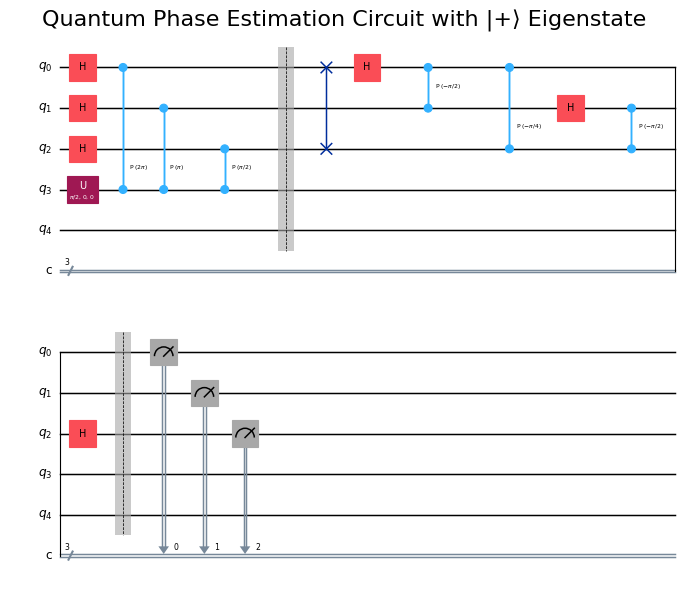

In [4]:
if __name__ == "__main__":
    import sys
    main()